# Boson sampling on a multimode coherent state

We test the boson sampling operator (no training) 
on coherent states

We compare with theory

nonlinearxwaves@gmail.com<br>
@created 27 january 2021<br>
@version 3 may 2023<br<

In [1]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
import matplotlib.pyplot as plt

2023-05-03 18:29:00.518517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-03 18:29:00.518538: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [3]:
tf.keras.backend.clear_session()

In [4]:
np.set_printoptions(precision=2)

Check GPU

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-05-03 18:29:08.988350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-03 18:29:08.988451: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-03 18:29:08.988578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist


## Dimension

In [6]:
N = 4

In [7]:
n=np.floor_divide(N,2)

## Build vacuum by the Gaussian state

In [8]:
vacuum = ps.VacuumLayer(N)

2023-05-03 18:29:13.184905: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Displacer

Define the alpha vector for the alpha

In [9]:
alpha=np.zeros([2],dtype=np_complex)

In [10]:
alpha[0]=np.exp(1j*np.pi/3)
alpha[1]=1.5
print(alpha)
print(np.abs(alpha)**2)

[0.5+0.87j 1.5+0.j  ]
[1.   2.25]


Define the corresponding displacement vector

In [11]:
dinput_np=np.zeros([N,1], dtype=np_real)
for j in range(n):
    dinput_np[2*j]=np.sqrt(2)*np.real(alpha[j])
    dinput_np[2*j+1]=np.sqrt(2)*np.imag(alpha[j])

In [12]:
dinput = tf.constant( dinput_np, dtype=vacuum.dtype)
displacer = ps.DisplacementLayerConstant(dinput)

## Build the model

In [13]:
xin = tf.keras.layers.Input(N)
x1, a1 = displacer(xin)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

# Evaluate the covariance

In [14]:
cov_layer = ps.CovarianceLayer(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
squeezed_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=squeezed_cov(xtrain); print(d0); tf.print(cov0)

tf.Tensor([[0.71 1.22 2.12 0.  ]], shape=(1, 4), dtype=float32)
[[1 -0 -0 -0]
 [-0 0.999999762 -0 -0]
 [-0 -0 1 -0]
 [-0 -0 -0 1]]


# Evaluate the Qtransform with calculated covariance and displacemente

In [15]:
Qrho = ps.QTransform(cov0, d0)

# Test the Pr operator 

Probability of zero photon

In [16]:
ps.Pr([0,0], Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04]], dtype=float32)>

Probability of two photons

In [17]:
ps.Pr([0,2], Qrho)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>

## Define a function with the expected theoretical value

In [18]:
def theoryPr(nbar, alpha):
    # returh the theory value for the Boson sampling for coherent states
    n=len(nbar)
    
    scale = 1
    for j in range(n):
        nj = nbar[j]
        aj2 = np.abs(alpha[j])**2
        scale = scale/np.math.factorial(nj)
        scale = scale*np.exp(-aj2)*np.power(aj2,nj)
    
    return scale  

## Compare with some examples

In [19]:
nbar=[0,0]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[[0.038774211]]
0.03877420783172201


In [20]:
nbar=[1,0]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0.0387742147]
0.03877420783172201


In [21]:
nbar=[1,1]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0.0872419775]
0.08724196762137452


In [22]:
nbar=[2,3]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0.0368051939]
0.03680520509026738


## Make a plot versus the probability

Build an array of photon number sampling

In [23]:
nmax=3 # max number of photons
# generate the combinations
import itertools as it
nlist=it.product(range(nmax+1),repeat=n)
ln=list(nlist)
print(ln)
print(len(ln))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
16


In [27]:
%%time 
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Computing Pn at n '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    Pth[nbar]=theoryPr(ln[nbar],alpha)
    print(Pth[nbar])
    xaxis[nbar]=nbar
print('Done')

Computing Pn at n (0, 0)
0.03877421
0.038774207
Computing Pn at n (0, 1)
0.08724196
0.08724197
Computing Pn at n (0, 2)
0.098147206
0.09814721
Computing Pn at n (0, 3)
0.073610395
0.07361041
Computing Pn at n (1, 0)
0.038774215
0.038774207
Computing Pn at n (1, 1)
0.08724198
0.08724197
Computing Pn at n (1, 2)
0.09814721
0.09814721
Computing Pn at n (1, 3)
0.07361041
0.07361041
Computing Pn at n (2, 0)
0.019387107
0.019387104
Computing Pn at n (2, 1)
0.04362099
0.043620985
Computing Pn at n (2, 2)
0.0490736
0.049073607
Computing Pn at n (2, 3)
0.036805194
0.036805205
Computing Pn at n (3, 0)
0.006462368
0.006462368
Computing Pn at n (3, 1)
0.014540324
0.014540328
Computing Pn at n (3, 2)
0.016357865
0.016357869
Computing Pn at n (3, 3)
0.012268395
0.012268402
Done
CPU times: user 4min 34s, sys: 1.22 s, total: 4min 36s
Wall time: 4min 36s


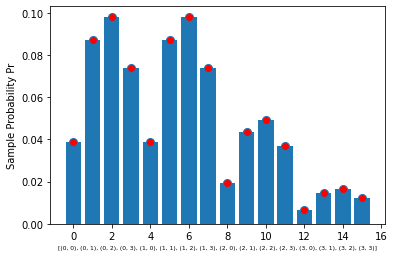

In [28]:
plt.bar(xaxis,Pn)
plt.plot(xaxis, Pth, marker='o', markersize=8, markerfacecolor='red', linestyle='none')
plt.xlabel(ln, fontsize=6);
plt.ylabel('Sample Probability Pr');
plt.savefig('BosonSamplingExample3.pdf', format='pdf')

Comparison between the photon number evaluated with the model(bars) and the theory (red dots). Sampling patters are indicate in the labels.